# Load data from Vizier

#### Index<a name="index"></a>
1. [Import packages](#imports)
2. [Load raw data](#loadData)
3. [Create and save data](#createData)
    1. [True clusters](#createTrue)
    2. [Non clusters - Uniform](#createUniformNonClusters)
    3. [Non clusters - Functional](#createFunctionalNonClusters)

## 1. Import packages<a name="imports"></a>

In [2]:
pip install --pre astroquery

     |████████████████████████████████| 4.4 MB 4.0 MB/s 
     |████████████████████████████████| 802 kB 66.0 MB/s 
     |████████████████████████████████| 54 kB 1.4 MB/s 
     |████████████████████████████████| 3.0 MB 46.7 MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=32a0409e541fa0f7b828e930be567d2db2016249245f2fd6c42c27c893f3db48
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
Successfully built mimeparse


In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from astroquery.vizier import Vizier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Aestetic settings

In [4]:
%matplotlib inline

sns.set(font_scale=1.3, style="ticks")

## 2. Load raw data<a name="loadData"></a>

In [5]:
Vizier.ROW_LIMIT = 3000000
catalogs = Vizier.get_catalogs('J/A+A/618/A93/members')
print(catalogs)  # astroquery.utils.commons.TableList

TableList with 1 tables:
	'0:J/A+A/618/A93/members' with 16 column(s) and 401448 row(s) 


Since `catalogs` only has 1 table, we are only interested in `catalogs[0]`. We will transform it to a `pandas` Data Frame for ease of handling.

In [6]:
catalog = catalogs[0].to_pandas()
catalog = catalog.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)
catalog.head()



,RA_ICRS,DE_ICRS,Source,GLON,GLAT,plx,pmRA,pmDE,o_Gmag,Gmag,BP-RP,PMemb,Cluster,SimbadName,_RA.icrs,_DE.icrs
0,301.229391,-11.186849,4190669036038417152,30.982256,-21.322445,2.1358,1.268,-8.560,348,14.804825,1.412944,0.7,Alessi_10,,301.229385,-11.186812
1,301.014346,-11.419202,4190657903483144960,30.660791,-21.229051,2.2071,1.136,-8.043,331,17.350530,2.605459,1.0,Alessi_10,Gaia DR2 4190657903483144960,301.014341,-11.419167
2,300.801432,-11.195500,4190723255705770240,30.783967,-20.945461,2.0438,1.259,-8.064,329,12.473157,0.865277,0.8,Alessi_10,,300.801426,-11.195466
3,301.006976,-11.037219,4190732120518267776,31.028893,-21.061430,2.3256,1.189,-8.100,301,16.400896,1.935030,1.0,Alessi_10,Gaia DR2 4190732120518267776,301.006971,-11.037184
4,301.678011,-10.865093,4190774206899418880,31.495512,-21.585570,2.2585,1.598,-7.630,322,17.435835,2.370981,1.0,Alessi_10,Gaia DR2 4190774206899418880,301.678004,-10.865060


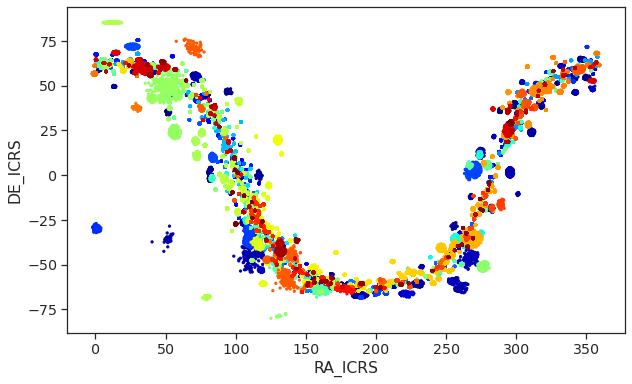

In [92]:
#plot the Cluster position 
dic = {label:idx for idx,label in enumerate(np.unique(catalog['Cluster']))}
catalog['Cluster'] = catalog['Cluster'].map(dic)
df = pd.DataFrame(catalog)
df.plot.scatter('RA_ICRS','DE_ICRS',colorbar=False, c='Cluster' ,marker='.',cmap='jet',figsize=(10,6))


## 3. Create and save data<a name="createData"></a>

First choose if you want to see in the notebook the scatter plots and histograms created.

In [7]:
plot_scatter = False
plot_hist = True

In [8]:
data_folder = '/content/drive/MyDrive/Random-forest-open-cluster-master/data'

### 3.1. True clusters<a name="createTrue"></a>

In [ ]:
clusters = np.unique(catalog['Cluster'])
number_clusters = len(clusters)


true_clusters_2d_hist = []
num = []
for i, cluster in enumerate(clusters):
    is_cluster = catalog['Cluster'] == cluster
    data_cluster = catalog[is_cluster]
    
    
    # Remove stars for which Gaia didn't measure magnitude or colour
    ra = data_cluster['RA_ICRS']
    dec = data_cluster['DE_ICRS']
    gmag = data_cluster['Gmag']
    bp_rp = data_cluster['BP-RP']
    is_nan = (np.isnan(bp_rp)) | (np.isnan(gmag))
    data_cluster = data_cluster[~is_nan]
    
    gmag = data_cluster['Gmag']
    bp_rp = data_cluster['BP-RP']


    if plot_scatter:
      plt.scatter(ra, dec, c=randomcolor(), marker='.')
      plt.xlabel(r'$B_p - R_p$ (mag)')
      plt.ylabel(r'$G$ (mag)')
      #plt.title(f'Cluster {cluster}')
      #plt.ylim([18,8])
      plt.show()

    
    hist, xedges, yedges = np.histogram2d(bp_rp, gmag, bins=20, 
                                          density=True)
    num.append(len(data_cluster))
    plt.imshow(hist, interpolation='nearest')
    plt.title(f'Cluster {cluster}')
    if i < 10:
      plt.savefig(f'{data_folder}/example_plots/true_clusters/{cluster}.jpg', bbox_inches='tight')
    if plot_hist:
        plt.show()
    plt.close()

    hist_linear = hist.reshape((400))
    true_clusters_2d_hist.append(hist_linear)
true_clusters_2d_hist_file = f'{data_folder}/true_clusters_2d_hist_{number_clusters}.npy'
#np.save(true_clusters_2d_hist_file, true_clusters_2d_hist)

Confirm the file was well saved by loading it. If the output of the cell is False, the saving went wrong.

In [ ]:
true_clusters_2d_hist_saved = np.load(true_clusters_2d_hist_file, allow_pickle=True)
np.allclose(true_clusters_2d_hist_saved, true_clusters_2d_hist)

In [ ]:
print('Number of positive samples: ', len(true_clusters_2d_hist))

### 3.2. DBSCAN <a name="createoutsideNonClusters"></a>

In [31]:
import sklearn.cluster
from astroquery.gaia import Gaia
import numpy as np
from astropy.io import fits
from astropy.table import Table

ra = 272.96
dec = -18.53932068
angle_first = 3

job = Gaia.launch_job_async("SELECT ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, bp_rp \
                             FROM gaiaedr3.gaia_source WHERE 1=CONTAINS(POINT('ICRS',ra,dec),  CIRCLE('ICRS',"+str(ra) +" , "+str(dec) +" , "+ str(angle_first)+" )) \
                             and abs(parallax_over_error) > 5 and parallax > 0.2 and phot_g_mean_mag < 17")

r = job.get_results()
#print r

#for i in ra

r.write('tst.hdf', path='./tst.hdf',format='hdf5')




INFO: Query finished. [astroquery.utils.tap.core]


In [33]:
import sklearn.cluster
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import sys
import itertools
from scipy import linalg
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import Angle
Vizier.ROW_LIMIT = -1

table = Vizier.query_region(coord.SkyCoord(ra=272.96, dec=-18.53932068, unit=(u.deg, u.deg), frame='icrs'),catalog='J/A+A/618/A93/table1', radius=Angle(3, "deg"))
#table = Vizier.get_catalogs('J/A+A/618/A93/table1')
tm=table[0]



t = Table.read('tst.hdf', format='hdf5') #gaia data


#print (len(tm['RAJ2000'])) #real OC ra






In [34]:
len(t['ra'])

371195

Number of stars:  371195
Number of clusters:  32
Nan
Nan
Nan
Nan
k =  0 477 274.61435451269887 -18.414773414048938 0.3414164120744951 0.13316356210529487 -2.0528796803275475
Found?  1
k =  1 62 272.6463909314628 -16.73033923155276 0.6718763833892284 -0.011862529386966808 -0.7817451220144798
Found?  1
k =  2 54 272.58992274678656 -16.72737698922844 0.5225190241631277 -1.0002032696700511 -1.6351375730844093
Found?  1
k =  3 18 273.1395977748738 -16.438682008403777 0.5191974052819004 0.5304775762331702 0.5223368584771539
Found?  0
k =  4 37 273.0289172266131 -15.977041182452876 0.3986959088291 0.34381863240410837 -0.6773366902653483
Found?  0
k =  5 25 272.1411097226216 -21.083086736318464 0.37204298570267513 -1.2469502093189524 -2.5942241110745647
Found?  0
k =  6 23 273.47604573613177 -21.06250243984831 0.7805638826185751 0.815629930393666 -0.9378715813114177
Found?  0
Nan
k =  7 58 272.45511650075525 -21.43172588215007 0.3559656344723682 0.051418207389648474 -1.1017661780731178
Found? 

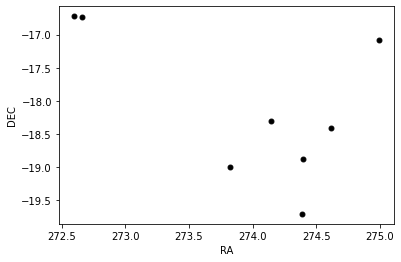

We have managed to identify:  7  out of  8
Size of noncluster list:  32


In [35]:
X = np.array([t['ra'], t['dec'], t['parallax'], t['pmra'], t['pmdec'] ])

Xfull = np.array([t['ra'], t['dec'], t['parallax'], t['pmra'], t['pmdec'], t['phot_g_mean_mag'], t['bp_rp'] ])

Xnew = np.transpose(X)

#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(Xnew)
Xnn = imp.transform(Xnew)

Xnew = StandardScaler().fit_transform(Xnn)

Xfull_new = np.transpose(Xfull)


print ('Number of stars: ', len(t['ra']))

clustering = DBSCAN(eps=0.0711, min_samples=17).fit(Xnew)


labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print ('Number of clusters: ', n_clusters_)

unique_labels = set(labels)

unique_labels.remove(-1)

known_cluster = [] ## it says if the given cluster is known as an open cluster

nonclusters = [5,12,14]

false_mtr = []

for k in unique_labels:

	class_member_mask = (labels == k)

	cluster_items = Xfull_new[class_member_mask]

	ra_cl  = np.array (t['ra'])
	dec_cl = np.array (t['dec']) 
	par_cl = np.array (t['parallax'])
	pmra_cl = np.array (t['pmra'])
	pmdec_cl = np.array (t['pmdec']) 
	gm_cl    = np.array (t['phot_g_mean_mag'])
	gc_cl    = np.array (t['bp_rp'])

	ra_cl   = ra_cl    [class_member_mask]
	dec_cl  = dec_cl   [class_member_mask]
	par_cl  = par_cl   [class_member_mask]
	pmra_cl = pmra_cl  [class_member_mask]
	pmdec_cl= pmdec_cl [class_member_mask]
	gm_cl   = gm_cl    [class_member_mask]
	gc_cl   = gc_cl    [class_member_mask]

	#gm_cl = gm_cl[gm_cl]
	#gc_cl = gc_cl[gc_cl]

	gm_cl1 = []
	gc_cl1 = []

	for jc in range (0, len(gm_cl)): ## filter out nan values (when Gaia could not measure the color)

		#print ('--> ', gm_cl[jc], gc_cl[jc])

		if (gc_cl[jc] != gc_cl[jc] or gm_cl[jc] != gm_cl[jc]):
			print ('Nan')	
		else:	
			gm_cl1.append (gm_cl[jc])
			gc_cl1.append (gc_cl[jc])

	#sys.exit(0)

		#if gm_cl[jc]


	ra_cl_mean    = np.mean (ra_cl)
	dec_cl_mean   = np.mean (dec_cl)
	par_cl_mean   = np.mean (par_cl)
	pmra_cl_mean  = np.mean (pmra_cl)
	pmdec_cl_mean = np.mean (pmdec_cl)

	print ('k = ', k, len(ra_cl), ra_cl_mean, dec_cl_mean, par_cl_mean, pmra_cl_mean, pmdec_cl_mean)
	

	flag_found = 0
	for j in range (0, len (tm['RAJ2000'])):

		if (abs(ra_cl_mean - tm['RAJ2000'][j]) < 0.15) and (abs(dec_cl_mean - tm['DEJ2000'][j]) < 0.15) and (abs(par_cl_mean - tm['plx'][j]) < 0.3) and (abs(pmra_cl_mean - tm['pmRA'][j]) < 0.5) and (abs(pmdec_cl_mean - tm['pmDE'][j]) < 0.5):
			flag_found = 1
			break
	known_cluster.append (flag_found)

	print ('Found? ', flag_found)

	#if k in nonclusters:
	  #print ('k = ', k, 'we found it in the list')
	H, xedges, yedges = np.histogram2d (gc_cl1, gm_cl1, bins=20, density=True)

	H1 = H.reshape ((400))

	false_mtr.append (H1)

	#if k in nonclusters:
#		sys.exit(0)

	#plt.scatter (ra_cl, dec_cl, s=4)
   

	#if flag_found == 0:

	  #plt.imshow(H, interpolation='nearest')
    #plt.scatter (gc_cl, gm_cl)
		#plt.title (str(k))
		#plt.ylim([np.max(gm_cl), np.min(gm_cl)])	
	  #plt.show()	

	#if k > 7:
	#	sys.exit(0)

plt.scatter (tm['RAJ2000'], tm['DEJ2000'], s=24,c="black")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.show()

print ('We have managed to identify: ', np.sum(known_cluster), ' out of ', len(tm['RAJ2000']))

print ('Size of noncluster list: ', len(false_mtr))

false_file = f'{data_folder}/matrix_false_nonclusters.npy'
#np.save(non_clusters_2d_hist_file, non_clusters_2d_hist)
np.save (false_file, false_mtr)



### 3.3. Non clusters - Outside OCs & DBSCAN<a name="createoutsideNonClusters"></a>

In [25]:
non_clusters_2d_hist = []

In [26]:
import sklearn.cluster
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import sys
import itertools
from scipy import linalg
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import Angle
from astroquery.gaia import Gaia
Vizier.ROW_LIMIT = -1

table = Vizier.query_region(coord.SkyCoord(ra=272.96, dec=-18.53932068, unit=(u.deg, u.deg), frame='icrs'),catalog='J/A+A/618/A93/table1', radius=Angle(300, "deg"))
tm=table[0]


#print (tm['Cluster']) #real OC ra
np.random.seed(13)
index = np.random.randint(0, len(tm['Cluster']), size=13)
index





array([338, 176,  74, 742, 866, 153, 748, 922, 638, 942, 229, 843, 770])

In [27]:
gamg = []
bprp = []

for num in index:
  #num = 1
  ra = tm['RAJ2000'][num]
  dec = tm['DEJ2000'][num]
  angle_first = 2
  count = 0

  job = Gaia.launch_job_async("SELECT ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, bp_rp \
                                FROM gaiaedr3.gaia_source WHERE 1=CONTAINS(POINT('ICRS',ra,dec),  CIRCLE('ICRS',"+str(ra) +" , "+str(dec) +" , "+ str(angle_first)+" )) \
                                and abs(parallax_over_error) > 5 and parallax > 0.1 and phot_g_mean_mag < 18")

  r = job.get_results()
  #r.write('tst.hdf', path='./tst.hdf',format='hdf5')

  #t = Table.read('tst.hdf', format='hdf5') #gaia data 
  X = np.array([r['ra'], r['dec'], r['parallax'], r['pmra'], r['pmdec'] ])

  Xfull = np.array([r['ra'], r['dec'], r['parallax'], r['pmra'], r['pmdec'], r['phot_g_mean_mag'], r['bp_rp'] ])

  Xnew = np.transpose(X)

  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp = imp.fit(Xnew)
  Xnn = imp.transform(Xnew)

  Xnew = StandardScaler().fit_transform(Xnn)

  Xfull_new = np.transpose(Xfull)


  print ('Number of stars: ', len(r['ra']))

  clustering = DBSCAN(eps=0.0711, min_samples=17).fit(Xnew)


  labels = clustering.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

  print ('Number of clusters: ', n_clusters_)

  unique_labels = set(labels)

  unique_labels.remove(-1)

  ra_cl  = np.array (r['ra'])
  dec_cl = np.array (r['dec']) 
  par_cl = np.array (r['parallax'])
  pmra_cl = np.array (r['pmra'])
  pmdec_cl = np.array (r['pmdec']) 
  gm_cl    = np.array (r['phot_g_mean_mag'])
  gc_cl    = np.array (r['bp_rp'])

  for k in unique_labels:
    class_member_mask = (labels == k)
    cluster_items = Xfull_new[class_member_mask]

    ra_cl_   = ra_cl    [class_member_mask]
    dec_cl_  = dec_cl   [class_member_mask]
    par_cl_ = par_cl   [class_member_mask]
    pmra_cl_ = pmra_cl  [class_member_mask]
    pmdec_cl_= pmdec_cl [class_member_mask]
    gm_cl_   = gm_cl    [class_member_mask]
    gc_cl_   = gc_cl    [class_member_mask]
  

  for j in range(0,len(ra_cl)):
    if (abs(ra_cl[j] - ra) > 2*tm['r50'][num]) and (abs(dec_cl[j] - dec) > 2*tm['r50'][num]) and ra_cl[j] != ra_cl_.all and dec_cl[j] != dec_cl_.all:
      count = count + 1
    if (gc_cl[j] != gc_cl[j] or gm_cl[j] != gm_cl[j]):
      #print ('Nan') 
      pass
    else:
      gamg.append(gm_cl[j])
      bprp.append(gc_cl[j])
      count = 0
    #print(j)  
  print(gamg)

  for i in range(0,100): 

    number_stars = int(random.uniform(13,3629))
    
    idxs = np.random.randint(0, len(gamg), size=number_stars)
    ga_mg = [gamg[i] for i in idxs]
    bp_rp = [bprp[i] for i in idxs]

    gamg_new = np.array(random.sample(ga_mg,number_stars))
    bprp_new = np.array(random.sample(bp_rp,number_stars))


    hist, xedges, yedges = np.histogram2d(bprp_new, gamg_new, bins=20, density=True)
    
    if i <= 0:
      plt.imshow(hist, interpolation='nearest')
      plt.title(f'Non Cluster {i}')
    #plt.savefig(f'{data_folder}/example_plots/non_clusters/func_non_cluster_{i}.jpg', 
                        #bbox_inches='tight')
        
    if plot_hist:
        plt.show()
    plt.close()  
    
    hist_linear = hist.reshape((400))
    non_clusters_2d_hist.append(hist_linear) 
  gamg = [] 
  brbp = []
non_clusters_2d_hist_file = f'{data_folder}/non_clusters_2d_hist.npy'
np.save(non_clusters_2d_hist_file, non_clusters_2d_hist)
  


  

Output hidden; open in https://colab.research.google.com to view.

In [28]:
  len(non_clusters_2d_hist)

1300

In [ ]:
np.save(non_clusters_2d_hist_file, non_clusters_2d_hist)

In [29]:
non_clusters_2d_hist_saved = np.load(non_clusters_2d_hist_file, allow_pickle=True)
#np.shape(non_clusters_2d_hist_saved)
np.allclose(non_clusters_2d_hist_saved, non_clusters_2d_hist)

True